# GTEx Analysis

In [1]:
import glob
import os
import random

import cdpybio as cpb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None
from scipy.stats import fisher_exact
import seaborn as sns

import ciepy
import cardipspy as cpy

%matplotlib inline

outdir = os.path.join(ciepy.root, 'output',
                      'gtex_analysis')
cpy.makedir(outdir)

private_outdir = os.path.join(ciepy.root, 'private_output',
                              'gtex_analysis')
cpy.makedir(private_outdir)

In [2]:
sns.set_style('whitegrid')

In [3]:
rna_meta = pd.read_table(os.path.join(ciepy.root, 'output', 'input_data', 'rnaseq_metadata.tsv'),
                         index_col=0)

From the GTEx supplement: "For a given tissue, genes having at least 0.1 RPKM in 2 or more individuals were retained."
All of the expression matrices only include genes that pass this filter. So I think they tested
all genes in their expression matrices for eQTLs.

In [4]:
# Single tissue results.
fns = glob.glob('/publicdata/gtex_v6/*.snpgenes')
gtex_results = {}
for fn in fns:
    print(os.path.split(fn)[1][:-18])
    gtex_results[os.path.split(fn)[1][:-18]] = pd.read_table(fn, index_col=0,
                                                             low_memory=False)
    
# Single tissue expression matrices.
fns = glob.glob('/publicdata/gtex_v6/*.expr.txt')
gtex_exp = {}
for fn in fns:
    print(os.path.split(fn)[1][:-18])
    gtex_exp[os.path.split(fn)[1][:-18]] = pd.read_table(fn, index_col=0,
                                                         low_memory=False)

Brain_Hippocampus
Nerve_Tibial
Brain_Cortex
Adrenal_Gland
Skin_Not_Sun_Exposed_Suprapubic
Brain_Cerebellum
Cells_Transformed_fibroblasts
Pituitary
Liver
Esophagus_Mucosa
Artery_Tibial
Brain_Cerebellar_Hemisphere
Colon_Transverse
Heart_Atrial_Appendage
Colon_Sigmoid
Pancreas
Muscle_Skeletal
Artery_Coronary
Heart_Left_Ventricle
Esophagus_Gastroesophageal_Junction
Brain_Nucleus_accumbens_basal_ganglia
Brain_Hypothalamus
Ovary
Whole_Blood
Esophagus_Muscularis
Brain_Putamen_basal_ganglia
Adipose_Subcutaneous
Skin_Sun_Exposed_Lower_leg
Stomach
Adipose_Visceral_Omentum
Lung
Thyroid
Brain_Frontal_Cortex_BA9
Breast_Mammary_Tissue
Brain_Anterior_cingulate_cortex_BA24
Testis
Spleen
Prostate
Vagina
Brain_Caudate_basal_ganglia
Cells_EBV-transformed_lymphocytes
Uterus
Small_Intestine_Terminal_Ileum
Brain_Nucleus_accumbens_basal_ganglia
Brain_Putamen_basal_ganglia
Brain_Cerebellar_Hemisphere
Breast_Mammary_Tissue
Stomach
Thyroid
Adipose_Subcutaneous
Heart_Atrial_Appendage
Vagina
Colon_Transverse
Cell

In [5]:
# Add Ensembl gene ID.
for k in gtex_results.keys():
    gtex_results[k]['ens_gene_id'] = gtex_results[k]['gene'].apply(lambda x: x.split('.')[0])

In [6]:
gene_info = pd.read_table(cpy.gencode_gene_info, index_col=0)

fn = os.path.join(ciepy.root, 'output', 'eqtl_processing', 
                  'eqtls01', 'qvalues.tsv')
qvalues = pd.read_table(fn, index_col=0)
fn = os.path.join(ciepy.root, 'output', 'eqtl_processing', 
                  'eqtls01', 'lead_variants.tsv')
lead_vars = pd.read_table(fn, index_col=0)
fn = os.path.join(ciepy.root, 'output', 'eqtl_processing', 
                  'eqtls01', 'lead_variants_single.tsv')
lead_vars_single = pd.read_table(fn, index_col=0)
lead_vars_single.gene_id = lead_vars_single.gene_id.apply(lambda x: x.split('.')[0])
lead_vars_single.index = [x.split('.')[0] for x in lead_vars_single.index]

sig = lead_vars[lead_vars.perm_sig == 1]
sig['ens_gene_id'] = sig.gene_id.apply(lambda x: x.split('.')[0])

fn = os.path.join(ciepy.root, 'output', 'eqtl_processing', 
                  'unrelated_eqtls01', 'lead_variants.tsv')
unr_lead_vars = pd.read_table(fn, index_col=0)
unr_sig = unr_lead_vars[unr_lead_vars.perm_sig == 1]
unr_sig['ens_gene_id'] = unr_sig.gene_id.apply(lambda x: x.split('.')[0])

## GTEx Summary

In [7]:
gtex_info = pd.DataFrame(index=gtex_results.keys())
gtex_info['num_sig_associations'] = [gtex_results[k].shape[0] for k in gtex_info.index]
gtex_info['num_sig_genes'] = [len(set(gtex_results[k].gene)) for k in gtex_info.index]
gtex_info['num_samples'] = [gtex_exp[k].shape[1] for k in gtex_info.index]
gtex_info['num_genes_tested'] = [gtex_exp[k].shape[0] for k in gtex_info.index]

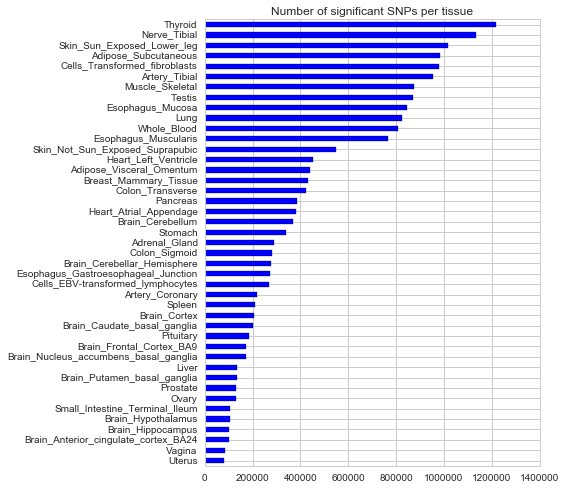

In [8]:
gtex_info.sort_values(by='num_sig_associations', inplace=True)
plt.figure(figsize=(6, 8))
ax = gtex_info.num_sig_associations.plot(kind='barh')
ax.set_title('Number of significant SNPs per tissue');

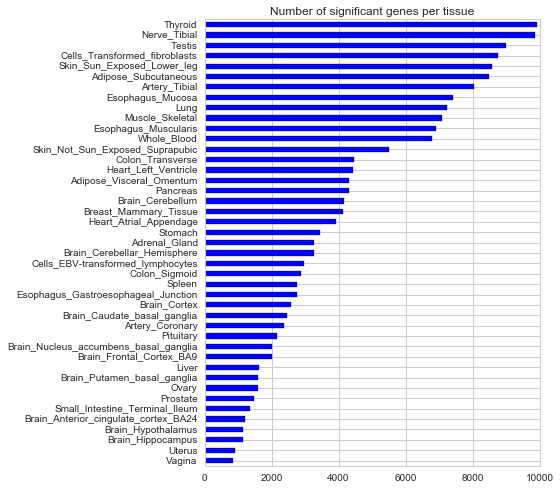

In [9]:
gtex_info.sort_values(by='num_sig_genes', inplace=True)
plt.figure(figsize=(6, 8))
ax = gtex_info.num_sig_genes.plot(kind='barh')
ax.set_title('Number of significant genes per tissue');

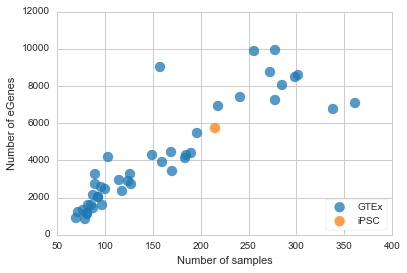

In [10]:
plt.scatter(gtex_info.num_samples, gtex_info.num_sig_genes, label='GTEx', 
            color=cpb.analysis.tableau20[0], s=100, alpha=0.75)
plt.scatter([rna_meta.in_eqtl.sum()], [len(set(sig.gene_id))], label='iPSC', 
            color=cpb.analysis.tableau20[2], alpha=0.75, s=100)

plt.xlabel('Number of samples')
plt.ylabel('Number of eGenes')
plt.legend(frameon=True, fancybox=True, loc='lower right')
plt.savefig(os.path.join(outdir, 'samples_vs_egenes.pdf'));

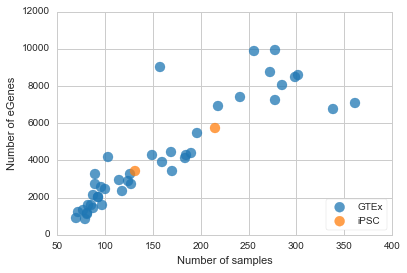

In [11]:
plt.scatter(gtex_info.num_samples, gtex_info.num_sig_genes, label='GTEx', 
            color=cpb.analysis.tableau20[0], s=100, alpha=0.75)
plt.scatter([131, rna_meta.in_eqtl.sum()], 
            [len(set(unr_sig.gene_id)), len(set(sig.gene_id))], label='iPSC', 
            color=cpb.analysis.tableau20[2], alpha=0.75, s=100)

plt.xlabel('Number of samples')
plt.ylabel('Number of eGenes')
plt.legend(frameon=True, fancybox=True, loc='lower right')
plt.savefig(os.path.join(outdir, 'samples_vs_egenes.pdf'));

## Direction of Effect

I want to check whether the direction of effect for my lead variants
agrees with the direction of effect for the same gene/variants in GTEx.

In [12]:
gtex_info.sort_values(by=['num_samples'], ascending=False, inplace=True)

In [13]:
agree = []
for k in gtex_info.index:
    tdf = gtex_results[k]
    t = sig.dropna(subset=['rsid'])
    t['rsid_gene'] = t.rsid + ':' + t.gene_id
    tdf['rsid_gene'] = tdf.rs_id_dbSNP142_GRCh37p13 + ':' + tdf.gene
    tdf = tdf.drop_duplicates(subset=['rsid_gene'])
    t.index = t.rsid_gene
    tdf.index = tdf.rsid_gene
    ind = set(tdf.rsid_gene) & set(t.rsid_gene)
    t = t.ix[ind]
    tdf = tdf.ix[ind]
    t['gtex_beta'] = tdf.ix[t.index, 'beta']
    c = pd.crosstab(t.beta > 0, t.gtex_beta > 0)
    c.ix[True, True] + c.ix[False, False] / c.sum().sum()
    agree.append((c.ix[True, True] + c.ix[False, False]) / float(c.sum().sum()))
gtex_info['percent_lead_beta_dir_agree'] = agree

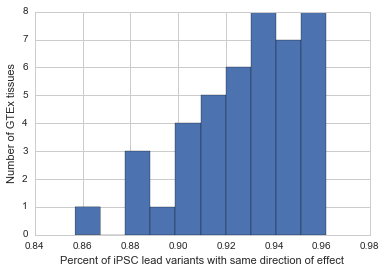

In [14]:
gtex_info.percent_lead_beta_dir_agree.hist()
plt.xlabel('Percent of iPSC lead variants with same direction of effect')
plt.ylabel('Number of GTEx tissues');

In [15]:
print('{:.1f}% of lead SNVs agree on direction of effect on average.'.format(
        gtex_info.percent_lead_beta_dir_agree.mean() * 100))

92.8% of lead SNVs agree on direction of effect on average.


## eQTL sharing

Given that a gene was an eQTL in iPSC, what is the probability 
that it was detected as an eQTL in a different tissue?

In [16]:
vals = []
for k in gtex_results.keys():
    sig_both = set(sig.gene_id) & set(gtex_results[k].gene)
    sig_gtex = set(gtex_results[k].gene) - set(sig.gene_id)
    sig_ipsc = set(sig.gene_id) - set(gtex_results[k].gene)
    tested_both = set(qvalues.index) & set(gtex_exp[k].index) - sig_both
    tested_gtex = set(gtex_exp[k].index) - set(qvalues.index) - sig_gtex
    tested_ipsc = set(qvalues.index) - set(gtex_exp[k].index) - sig_ipsc
    vals.append([len(sig_both), len(sig_gtex), len(sig_ipsc), 
                 len(tested_both), len(tested_gtex), len(tested_ipsc)])
cols = ['sig_both', 'sig_gtex', 'sig_ipsc', 'tested_both', 'tested_gtex', 'tested_ipsc']
df = pd.DataFrame(vals, index=gtex_results.keys(), columns=cols)
gtex_info = gtex_info.join(df)

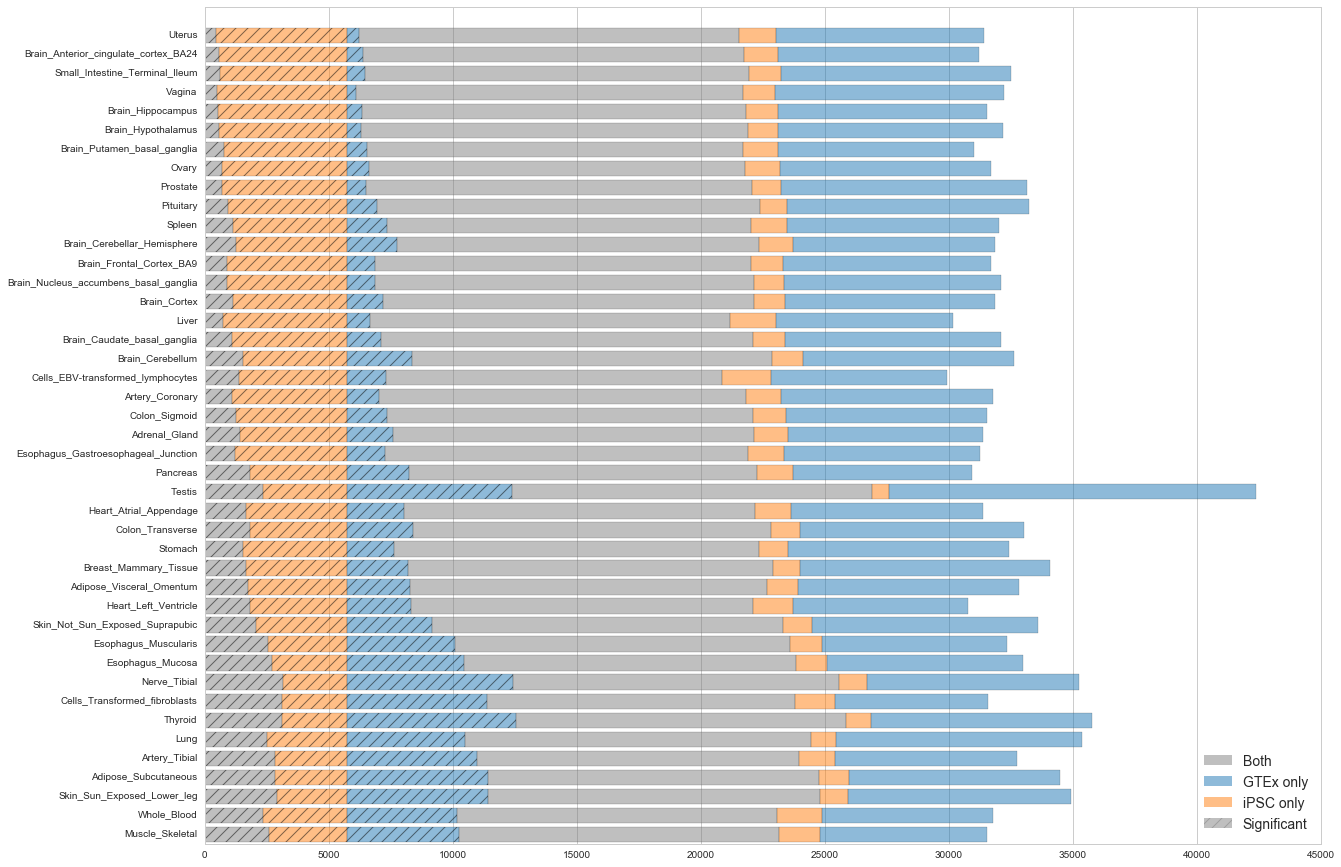

In [17]:
fig,ax = plt.subplots(1, 1, figsize=(20, 15))
left = np.zeros(gtex_info.shape[0])
for c in [u'sig_both', u'sig_ipsc', u'sig_gtex', u'tested_both', 
          u'tested_ipsc', u'tested_gtex']:
    if 'sig' in c:
        hatch = '//'
    else:
        hatch = None
    if 'gtex' in c:
        color = cpb.analysis.tableau20[0]
    elif 'ipsc' in c:
        color = cpb.analysis.tableau20[2]
    else:
        color = 'grey'
    ax.barh(np.arange(gtex_info.shape[0]) + 0.1, gtex_info[c], color=color, 
            alpha=0.5, hatch=hatch, left=left)
    left += gtex_info[c]
ax.set_yticks(np.arange(44) + 0.5)
ax.set_yticklabels(gtex_info.index)
ax.set_ylim(0, 44);

colors = {'Both':'grey', 'GTEx only':cpb.analysis.tableau20[0], 
          'iPSC only':cpb.analysis.tableau20[2]}
rects = []
labels = []
for k in ['Both', 'GTEx only', 'iPSC only']:
    labels.append(k)
    rects.append(plt.Rectangle((0, 0), 0, 0, fc=colors[k], alpha=0.5))
labels.append('Significant')
rects.append(plt.Rectangle((0, 0), 0, 0, color='grey', hatch='//', alpha=0.5))
lgd = ax.legend(rects, labels, loc='lower right', fancybox=True, prop={'size':14}) #,ncol=8)
for p in lgd.get_patches():
    p.set_linewidth(0)
ax.grid(axis='y')

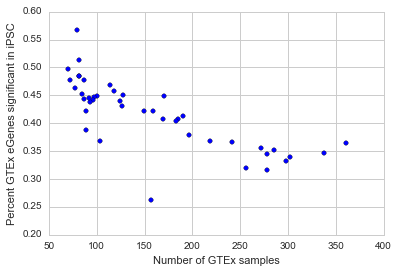

In [18]:
gtex_info['percent_gtex_in_ipsc'] = \
    [len(set(sig.gene_id) & set(gtex_results[k].gene)) / float(len(set(gtex_results[k].gene)))
     for k in gtex_info.index]
    
plt.scatter(gtex_info.num_samples, gtex_info.percent_gtex_in_ipsc)
plt.xlabel('Number of GTEx samples')
plt.ylabel('Percent GTEx eGenes significant in iPSC');

I'd like to see whether the iPSC eGenes are distinct in some way
compared to GTEx.

In [19]:
gtex_sig_genes = set()
t = []
for k in set(gtex_results.keys()):
    gtex_sig_genes |= set(gtex_results[k].gene)
    t += list(set(gtex_results[k].gene))
gtex_sig_genes_vc = pd.Series(t).value_counts()
gtex_info['gtex_num_distinct_egenes'] = \
    [sum(gtex_sig_genes_vc[set(gtex_results[k]['gene'])] == 1) for k in gtex_info.index]
gtex_info.sort_values(by='gtex_num_distinct_egenes', inplace=True, ascending=False)

In [20]:
print('There are {} GTEx tissues'.format(len(gtex_results)))
print('GTEx has found eQTLs for {:,} genes.'.format(len(gtex_sig_genes)))
f = (gene_info.ix[gtex_sig_genes, 'gene_type'].value_counts()['protein_coding'] / 
     float(gene_info.gene_type.value_counts()['protein_coding']))
print('{:.2f}% of protein coding genes have an eQTL in GTEx'.format(f * 100))

There are 43 GTEx tissues
GTEx has found eQTLs for 27,012 genes.
77.14% of protein coding genes have an eQTL in GTEx


I'm removing testis below since it's an outlier (and known to have weird
expression) so I can see the data better.

In [21]:
sig_genes = set(sig.gene_id)
t = []
for k in set(gtex_results.keys()) - set(['Testis']):
    sig_genes |= set(gtex_results[k].gene)
    t += list(set(gtex_results[k].gene))
sig_genes_vc = pd.Series(t).value_counts()
gtex_info['num_distinct_egenes'] = \
    [sum(sig_genes_vc[set(gtex_results[k]['gene'])] == 1) for k in gtex_info.index]
gtex_info.sort_values(by='num_distinct_egenes', inplace=True, ascending=False)

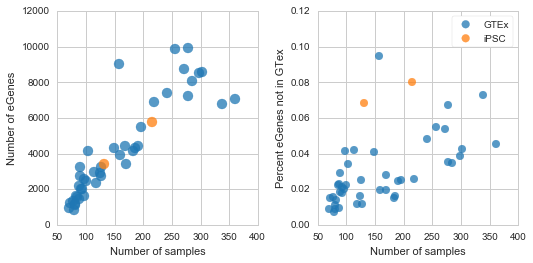

In [22]:
fig,axs = plt.subplots(1, 2, figsize=(7.5, 3.75))
ax = axs[0]
ax.scatter(gtex_info.num_samples, gtex_info.num_sig_genes, label='GTEx', 
            color=cpb.analysis.tableau20[0], s=100, alpha=0.75)
ax.scatter([131, rna_meta.in_eqtl.sum()], 
           [len(set(unr_sig.gene_id)), len(set(sig.gene_id))], label='iPSC', 
            color=cpb.analysis.tableau20[2], alpha=0.75, s=100)

ax.set_xlabel('Number of samples')
ax.set_ylabel('Number of eGenes')


ax = axs[1]
ax.scatter(gtex_info.num_samples, gtex_info.num_distinct_egenes / gtex_info.num_sig_genes.astype(float), 
            label='GTEx', color=cpb.analysis.tableau20[0], s=60, alpha=0.75)
ax.scatter([131, rna_meta.in_eqtl.sum()], 
           [(len(set(unr_sig.gene_id) - gtex_sig_genes)) / float(len(set(unr_sig.gene_id))),
            (len(set(sig.gene_id) - gtex_sig_genes)) / float(len(set(sig.gene_id)))], 
            label='iPSC', color=cpb.analysis.tableau20[2], alpha=0.75, s=60)
ymin,ymax = ax.get_ylim()
ax.set_ylim(0, ymax)

ax.set_xlabel('Number of samples')
ax.set_ylabel('Percent eGenes not in GTex')
ax.legend(frameon=True, fancybox=True)
fig.tight_layout()
plt.savefig(os.path.join(outdir, 'egenes_samples_and_distinct.pdf'));

In [23]:
gtex_info.num_distinct_egenes / gtex_info.num_sig_genes.astype(float)

Testis                                   0.094572
Thyroid                                  0.067425
Nerve_Tibial                             0.054665
Whole_Blood                              0.072966
Cells_Transformed_fibroblasts            0.053881
Skin_Sun_Exposed_Lower_leg               0.042255
Esophagus_Mucosa                         0.048139
Adipose_Subcutaneous                     0.038824
Muscle_Skeletal                          0.045185
Artery_Tibial                            0.034881
Lung                                     0.035102
Esophagus_Muscularis                     0.025593
Pancreas                                 0.040688
Brain_Cerebellum                         0.034110
Skin_Not_Sun_Exposed_Suprapubic          0.025314
Colon_Transverse                         0.028115
Cells_EBV-transformed_lymphocytes        0.041963
Heart_Left_Ventricle                     0.024677
Brain_Cerebellar_Hemisphere              0.029222
Adrenal_Gland                            0.025161


In [24]:
gtex_info.head()

,num_sig_associations,num_sig_genes,num_samples,num_genes_tested,percent_lead_beta_dir_agree,sig_both,sig_gtex,sig_ipsc,tested_both,tested_gtex,tested_ipsc,percent_gtex_in_ipsc,gtex_num_distinct_egenes,num_distinct_egenes
Testis,870733,9009,157,35670,0.886476,2370,6639,3376,14509,14768,709,0.263070,1914,852
Thyroid,1216881,9937,278,28519,0.902718,3135,6802,2611,13299,8910,1017,0.315488,569,670
Nerve_Tibial,1133462,9860,256,27807,0.915152,3156,6704,2590,13144,8546,1118,0.320081,458,539
Whole_Blood,806847,6784,338,23973,0.856836,2354,4430,3392,12913,6879,1813,0.346993,431,495
Cells_Transformed_fibroblasts,979113,8760,272,23789,0.935252,3116,5644,2630,12422,6172,1598,0.355708,410,472


In [25]:
import statsmodels.api as sm

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          num_sig_genes   R-squared:                       0.851
Model:                            OLS   Adj. R-squared:                  0.847
Method:                 Least Squares   F-statistic:                     228.8
Date:                Sat, 06 Aug 2016   Prob (F-statistic):           3.85e-18
Time:                        08:13:43   Log-Likelihood:                -350.99
No. Observations:                  42   AIC:                             706.0
Df Residuals:                      40   BIC:                             709.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
num_samples    29.3689      1.942     15.124      0.000        25.444    33.293
const        -586.8971    349.888     -1.677      0.101     -1294.047   120.253
==============================================================================
Omnibus:                        5.756   Durbin-Watson:                   1.838
Prob(Omnibus):                  0.056   Jarque-Bera (JB):                7.704
Skew:                           0.107   Prob(JB):                       0.0212
Kurtosis:                       5.087   Cond. No.                         387.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

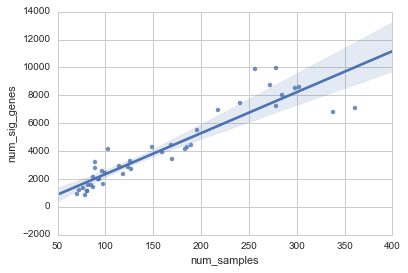

In [26]:
t = gtex_info.drop('Testis')
sns.regplot(t.num_samples, t.num_sig_genes);
t = sm.add_constant(t)
model = sm.OLS(t.num_sig_genes, t[['num_samples', 'const']])
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                             
=================================================================================
Dep. Variable:     percent_egenes_unique   R-squared:                       0.556
Model:                               OLS   Adj. R-squared:                  0.544
Method:                    Least Squares   F-statistic:                     50.00
Date:                   Sat, 06 Aug 2016   Prob (F-statistic):           1.50e-08
Time:                           08:13:44   Log-Likelihood:                -61.820
No. Observations:                     42   AIC:                             127.6
Df Residuals:                         40   BIC:                             131.1
Df Model:                              1                                         
Covariance Type:               nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
num_samples     0.0140      0.002      7.071      0.000         0.010     0.018
const           0.5066      0.358      1.415      0.165        -0.217     1.230
==============================================================================
Omnibus:                        4.423   Durbin-Watson:                   1.603
Prob(Omnibus):                  0.110   Jarque-Bera (JB):                4.200
Skew:                           0.731   Prob(JB):                        0.122
Kurtosis:                       2.487   Cond. No.                         387.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

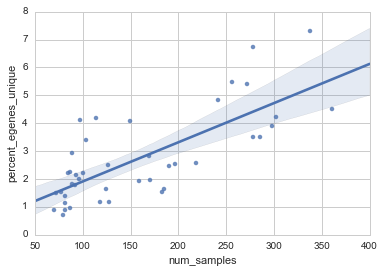

In [27]:
t = gtex_info.drop('Testis')
t['percent_egenes_unique'] = t.num_distinct_egenes / t.num_sig_genes.astype(float) * 100
sns.regplot(t.num_samples, t.percent_egenes_unique);
t = sm.add_constant(t)
model = sm.OLS(t.percent_egenes_unique, t[['num_samples', 'const']])
results = model.fit()
results.summary()

In [28]:
from statsmodels.sandbox.regression.predstd import wls_prediction_std

In [29]:
a = results.predict(exog=np.array([131, 1]))[0]
pred_stderr, pred_ci_low, pred_ci_high = wls_prediction_std(results, exog=[131, 1])
b = (len(set(unr_sig.gene_id) - gtex_sig_genes)) / float(len(set(unr_sig.gene_id))) * 100
print('Expected {:.2f}% unique eGenes ([{:.2f}, {:.2f}] 95% confidence interval), '
      'observed {:.2f}% for unrelateds.'.format(a, pred_ci_low[0], pred_ci_high[0], b))

Expected 2.35% unique eGenes ([0.13, 4.56] 95% confidence interval), observed 6.84% for unrelateds.


In [30]:
a = results.params[0] * 215 + results.params[1]
b = (len(set(sig.gene_id) - gtex_sig_genes)) / float(len(set(sig.gene_id))) * 100
print('Expected {:.2f}% unique eGenes, observed {:.2f}% for 215.'.format(a, b))

Expected 3.53% unique eGenes, observed 8.02% for 215.


For GTEx, each additional sample nets about 30 eGenes.

I'll make a data frame with info for the double scatter plot 
above so I can make figure for the paper.

In [31]:
out = pd.DataFrame(index=list(gtex_info.index) + ['ipsc_unrelateds', 'ipsc', 'lcl'], 
                   columns=['num_samples', 'num_sig_genes', 'source', 'percent_distinct_egenes'])
out.ix[gtex_info.index, ['num_samples', 'num_sig_genes']] = gtex_info[['num_samples', 'num_sig_genes']]
out.ix[gtex_info.index, 'percent_distinct_egenes'] = \
    gtex_info.num_distinct_egenes / gtex_info.num_sig_genes.astype(float)
out.ix[gtex_info.index, 'source'] = 'gtex'
out.ix['ipsc_unrelateds'] = [131, len(set(unr_sig.gene_id)), 'cardips', 
                             (len(set(unr_sig.gene_id) - gtex_sig_genes)) / float(len(set(unr_sig.gene_id)))]
out.ix['ipsc'] = [rna_meta.in_eqtl.sum(), len(set(sig.gene_id)), 'cardips', 
                  (len(set(sig.gene_id) - gtex_sig_genes)) / float(len(set(sig.gene_id)))]
out.to_csv(os.path.join(outdir, 'plot_data.tsv'), sep='\t')

In [32]:
gtex_info.to_csv(os.path.join(outdir, 'gtex_info.tsv'), sep='\t')